In [3]:

from transformers import pipeline

# Initialize QA pipeline
qa_pipeline = pipeline("question-answering")

# Define context and question
context = "Charles Babbage is considered the father of the computer. He invented the first mechanical computer in the 19th century."
question = "Who is considered the father of the computer?"

# Get prediction
result = qa_pipeline(question=question, context=context)
print(result)


No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


{'score': 0.997970461845398, 'start': 0, 'end': 15, 'answer': 'Charles Babbage'}


In [4]:
from transformers import pipeline

# Initialize with custom model
qa_pipeline_custom = pipeline("question-answering", model="deepset/roberta-base-squad2")

# Define context and question
context = "Charles Babbage is considered the father of the computer. He invented the first mechanical computer in the 19th century."
question = "Who is considered the father of the computer?"

# Get prediction
result_custom = qa_pipeline_custom(question=question, context=context)
print(result_custom)


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cpu


{'score': 0.9886763095855713, 'start': 0, 'end': 15, 'answer': 'Charles Babbage'}


In [5]:
# Custom context
context = "Ada Lovelace was a mathematician and writer. She is often regarded as the first computer programmer due to her work on the Analytical Engine."

# Questions
question1 = "Who was Ada Lovelace?"
question2 = "Why is Ada Lovelace famous?"

# Run both
print(qa_pipeline_custom(question=question1, context=context))
print(qa_pipeline_custom(question=question2, context=context))



{'score': 0.6183295845985413, 'start': 19, 'end': 43, 'answer': 'mathematician and writer'}
{'score': 0.12075834721326828, 'start': 19, 'end': 43, 'answer': 'mathematician and writer'}


Epoch 1/30 - D Loss: 0.1503 | G Loss: 3.6775
Epoch 2/30 - D Loss: 0.3758 | G Loss: 10.0234
Epoch 3/30 - D Loss: 0.0002 | G Loss: 9.9565
Epoch 4/30 - D Loss: 0.0004 | G Loss: 8.9615
Epoch 5/30 - D Loss: 0.0001 | G Loss: 9.7142
Epoch 6/30 - D Loss: 0.0001 | G Loss: 9.7813
Epoch 7/30 - D Loss: 0.0001 | G Loss: 12.2446
Epoch 8/30 - D Loss: 0.0000 | G Loss: 13.4159
Epoch 9/30 - D Loss: 0.0000 | G Loss: 13.7863
Epoch 10/30 - D Loss: 0.0000 | G Loss: 13.1647
Epoch 11/30 - D Loss: 0.0000 | G Loss: 13.5029
Epoch 12/30 - D Loss: 0.0000 | G Loss: 13.7801
Epoch 13/30 - D Loss: 0.0000 | G Loss: 14.5692
Epoch 14/30 - D Loss: 0.0000 | G Loss: 14.8574
Epoch 15/30 - D Loss: 0.0000 | G Loss: 14.7269
Epoch 16/30 - D Loss: 0.0000 | G Loss: 15.2007
Epoch 17/30 - D Loss: 0.0000 | G Loss: 15.5056
Epoch 18/30 - D Loss: 0.0000 | G Loss: 15.7967
Epoch 19/30 - D Loss: 0.0000 | G Loss: 15.8880
Epoch 20/30 - D Loss: 0.0000 | G Loss: 16.3716
Epoch 21/30 - D Loss: 0.0000 | G Loss: 16.4415
Epoch 22/30 - D Loss: 0.000

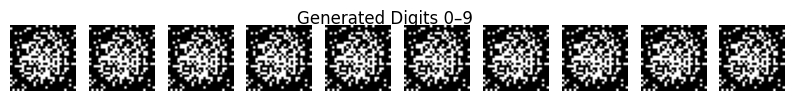

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 100
embedding_dim = 50
num_classes = 10
image_size = 28 * 28
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

# Label embedding
class EmbedLabel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embedding_dim)

    def forward(self, labels):
        return self.embed(labels)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embed = EmbedLabel()
        self.model = nn.Sequential(
            nn.Linear(z_dim + embedding_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat((noise, label_embedding), dim=1)
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embed = EmbedLabel()
        self.model = nn.Sequential(
            nn.Linear(image_size + embedding_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat((img.view(img.size(0), -1), label_embedding), dim=1)
        return self.model(x)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers and loss
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training loop
epochs = 30
for epoch in range(epochs):
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        # Real and fake labels
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, fake_labels)
        real_loss = criterion(discriminator(imgs, labels), real)
        fake_loss = criterion(discriminator(gen_imgs.detach(), fake_labels), fake)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels)
        g_loss = criterion(discriminator(gen_imgs, gen_labels), real)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Visualization: Generate one image per label 0–9
generator.eval()
with torch.no_grad():
    z = torch.randn(10, z_dim).to(device)
    labels = torch.arange(0, 10).to(device)
    gen_imgs = generator(z, labels).reshape(-1, 28, 28).cpu()

    plt.figure(figsize=(10, 1))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(gen_imgs[i], cmap='gray')
        plt.axis('off')
    plt.suptitle("Generated Digits 0–9")
    plt.show()